In [1]:
!pip install kagglehub timm --quiet

In [2]:
import kagglehub
from pathlib import Path

path = Path(kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset"))
print("Dataset path:", path)
print("Top-level folders:", list(path.iterdir()))

Dataset path: /kaggle/input/brain-tumor-mri-dataset
Top-level folders: [PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training'), PosixPath('/kaggle/input/brain-tumor-mri-dataset/Testing')]


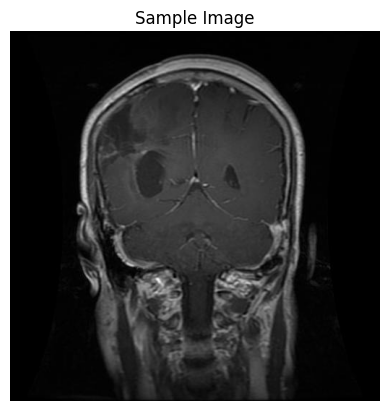

Image mode: RGB


In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Load one sample image to verify access
sample_image_path = path / "Training" / "glioma" / "Tr-gl_0010.jpg"
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")
plt.show()

print("Image mode:", img.mode)  # Expect 'RGB'

In [4]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# preprocessing transforms
# these transforms help the model generalize better and avoid overfitting
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resize all images to a fixed size, Vit's typically use 224 by 224
    transforms.RandomHorizontalFlip(), #flips images horizontally randomly
    transforms.RandomRotation(15), # randomly rotates images up to 15 degrees
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)), # random affine transformations which include geometric changes like rotating, translating, scaling, etc.
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # randomly tweaks with the brightness
    transforms.ToTensor(), #converts images to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #normalizing using ImageNet means and stds (our model is pretrained on ImageNet and then trained further on the dataset)
                         std=[0.229, 0.224, 0.225]),
])

train_dir = path / "Training"
test_dir = path / "Testing"

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Split training set into 90% train, 10% validation
train_size = int(0.9 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])

# loaders need to be added so the models can process the data in mini batches, which increases training speed
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_subset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
!pip install pytorch-lightning --quiet


In [11]:
"""Please note this is based on official pytorch lightning guidelines for building Lightning modules:
 https://lightning.ai/docs/pytorch/stable/common/lightning_module.html
and adapted using the timm library's pretrained ViT ("vit_tiny_patch16_224")
https://github.com/rwightman/pytorch-image-models
label smoothing and lagging methods follow best practices outlined in lightning docs and timm examples.
"""

import pytorch_lightning as pl
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViTLightningModel(pl.LightningModule):
    def __init__(self, num_classes=4, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

In [7]:
from pytorch_lightning.callbacks import EarlyStopping

model = ViTLightningModel(num_classes=4, lr=3e-4)

early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    precision="16-mixed",
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utili

In [8]:
trainer.fit(model, train_loader, validation_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 5.5 M  | train
1 | criterion | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.101    Total estimated model params size (MB)
265       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [9]:
#run test set evaluation
trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9412662386894226     │
│         test_loss         │    0.4862526059150696     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4862526059150696, 'test_acc': 0.9412662386894226}]

In [12]:
!git config --global user.email "sabel.matt@gmail.com"
!git config --global user.name "matthew-sabel"

In [13]:
!git clone https://github.com/richapatel93/brain-tumor-classification.git
%cd brain-tumor-classification

Cloning into 'brain-tumor-classification'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 815.18 KiB | 2.60 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/brain-tumor-classification


In [14]:
!cp /content/brain_tumor_vit_organized.ipynb /content/brain-tumor-classification/


cp: cannot stat '/content/brain_tumor_vit_organized.ipynb': No such file or directory


In [16]:
!find /content -name "brain_tumor_vit_organized.ipynb"